# Perform VoI calculation using GP surrogate over join action-uncertainty space for multiple buildings

In [1]:
import os
import json
import time
import numpy as np
from tqdm import tqdm

from scipy.stats import qmc
import sklearn.gaussian_process as gp
import scipy.optimize as op

import matplotlib.pyplot as plt
import matplotlib.tri as tri

import inspect
from multiprocessing import Pool

In [2]:
ids = [48,32]

In [3]:
# Define base parameters.
dataset_dir = os.path.join('data','A37_analysis_test') # dataset directory
opex_factor = 10
pricing_dict = {'carbon':5e-1,'battery':1e3,'solar':2e3}
with open(os.path.join(dataset_dir,'metadata_ext.json'),'r') as json_file:
        annex_defaults = json.load(json_file)
base_kwargs = {
    'output_dir_path': dataset_dir,
    'building_names': ['UCam_Building_%s'%id for id in ids],
    'battery_energy_capacities': None,
    'battery_power_capacities': [annex_defaults["building_attributes"]["battery_power_capacities (kW)"][str(id)] for id in ids],
    'battery_efficiencies': None,
    'pv_power_capacities': None,
    'load_data_paths': ['UCam_Building_%s.csv'%id for id in ids],
    'weather_data_path': 'weather.csv',
    'carbon_intensity_data_path': 'carbon_intensity.csv',
    'pricing_data_path': 'pricing.csv',
    'schema_name': 'schema_temp'
}

In [4]:
# Define multiprocessing helper functions.

n_processes = min(25,os.cpu_count()//2) # for some reason more than this is an issue ...? Maybe a memory issue

def multi_proc_constr_and_eval_system(args_list):

    from sys_eval import construct_and_evaluate_system

    return construct_and_evaluate_system(*args_list)

def parallel_task(func, iterable, n_procs):
    # Adapted from solution to https://stackoverflow.com/questions/47313732/jupyter-notebook-never-finishes-processing-using-multiprocessing-python-3/47374811
    # NOTE: this function must be in the notebook
    # NOTE: in this workaround, the function passed to `parallel_task`
    # must do all of the importing it needs, and unwrap the arguments
    # (only a single argument can be passed)

    temp_path = f'./tmp_func.py'
    with open(temp_path, 'w') as file:
        file.write(inspect.getsource(func).replace(func.__name__, "task"))

    from tmp_func import task

    if __name__ == '__main__':
        pool = Pool(processes=n_procs)
        res = list(tqdm(pool.imap(task, iterable), total=len(iterable)))
        pool.close()
        os.remove(temp_path)
        return res
    else:
        raise "Not in Jupyter Notebook"

## Step 1: Train GP Surrogate

Note: probably sensible to conduct an initial rough space search to identify sensible bounds as we expect the objective (cost) to be behaviour reasonably nicely, at least far from the region of the optimum.
The smaller the bounded region the better the surrogate will be and the easier the global optimisation will be - however as these bounds are arbitrary, if we encounter boundary solutions, the bounds need to be extended.

Remeber to note Dom's alternative suggestion for learning a surrogate, and it's motivation from the smoothness of his posterior solution results

In [5]:
# Perform sampling of action-uncertainty space
seed = 42
n_samples = 10000 # increase for final results?

# Space filling sampling of action sub-space using Latin Hypercube
lower_bounds = np.array([*[1e3,3e2],*[8e2,1e2]])
upper_bounds = np.array([*[1.4e3,7e2],*[1.2e3,5e2]])

action_sampler = qmc.LatinHypercube(d=len(ids)*2)
action_samples = action_sampler.random(n=n_samples)
action_samples = qmc.scale(action_samples, lower_bounds, upper_bounds)

# Sample from prior distributions of uncertain parameters
mu = 0.85
sigma = 0.1
eta_samples = np.random.normal(loc=mu,scale=sigma,size=(n_samples,len(ids)))
eta_samples = np.clip(eta_samples,0,1)

# Combine samples from two sub-spaces
space_samples = np.hstack([action_samples,eta_samples])

In [6]:
# Evaluate system cost over samples. (Old serial implementation)
# costs = []
# for n in tqdm(range(n_samples)):
#     cost = construct_and_evaluate_system(action_samples[n][:len(ids)],action_samples[n][len(ids):],eta_samples[n],base_kwargs,pricing_dict,opex_factor)
#     costs.append(cost)

In [7]:
# Evaluate system cost over samples. (Parallelised)
mproc_args_list = [[action_samples[n][:len(ids)],action_samples[n][len(ids):],eta_samples[n],base_kwargs,pricing_dict,opex_factor,n] for n in range(n_samples)]
space_sample_costs = parallel_task(multi_proc_constr_and_eval_system, mproc_args_list, n_procs=n_processes)

100%|██████████| 10000/10000 [15:53:19<00:00,  5.72s/it]  


### GP training

In [8]:
# Train Gaussian Process surrogate.

length_scale_init_guess = [*[50]*len(ids),*[40]*len(ids),*[0.1]*len(ids)]
kernel = 1 * gp.kernels.RBF(length_scale=np.array(length_scale_init_guess))
gp_surrogate = gp.GaussianProcessRegressor(kernel=kernel,normalize_y=True, n_restarts_optimizer=5)
start = time.time()
gp_surrogate.fit(space_samples, space_sample_costs)
end = time.time()
gp_surrogate.kernel_

0.474**2 * RBF(length_scale=[214, 197, 99.9, 54.3, 0.105, 0.261])

In [9]:
print(f"GP surrogate training time: {round(end-start,1)}")

GP surrogate training time: 3445.8


NOTE!!! Training the GP properly seems to be a bit of an issue - the length scales that comes out of the optimiser are sometimes completely off - having a good initialisation to the optimisation seems important

In [10]:
mean_prediction, std_prediction = gp_surrogate.predict(space_samples, return_std=True)

## Step 2: Solve Prior Problem using Surrogate

In [11]:
# Define fn for system cost predicted by surrogate.
def single_surrogate_estimate(x, surrogate, eta):

    assert len(x) % 2 == 0, "Design variable argument must have even length."

    predict_point = [np.hstack([x,np.array(eta)])]
    mean_prediction = surrogate.predict(predict_point)

    return mean_prediction

# Define fn of mean system cost predicted by surrogate.
def mean_cost_surrogate_estimate(x, surrogate, n_MC_samples, eta_mu, eta_sigma):

    assert len(x) % 2 == 0, "Design variable argument must have even length."

    # Make draw from distribution of uncertainties - specified in args (mu, sigma)
    # ========================================================================
    eta_samples = np.random.normal(loc=eta_mu,scale=eta_sigma,size=(n_MC_samples,len(ids)))
    eta_samples = np.clip(eta_samples,0,1)

    # Predict costs for each efficiency sample at target point using surrogate
    # ========================================================================
    predict_points = np.hstack([np.tile(x,(n_MC_samples,1)),eta_samples])
    mean_prediction = surrogate.predict(predict_points)

    return np.mean(mean_prediction)

In [12]:
bounds = op.Bounds(lb=lower_bounds,ub=upper_bounds)
n_surrogate_MC_samples = 5000

In [13]:
start = time.time()
prior_soln = op.differential_evolution(mean_cost_surrogate_estimate, bounds, args=(gp_surrogate,n_surrogate_MC_samples,mu,sigma), seed=seed)
end = time.time()
print(prior_soln.x, prior_soln.fun, prior_soln.nfev, prior_soln.message)
prior_design = prior_soln.x
prior_cost = prior_soln.fun
print(f"Prior solution: {prior_design}")
print(f"Predicted prior solution cost: {round(prior_cost,2)}")
print(f"Prior problem solve time: {round(end-start,1)}")
print(prior_soln.nfev)

[1113.83033762  614.94568194 1016.11607335  335.33918873] 9931466.329845376 360 Optimization terminated successfully.
Prior solution: [1113.83033762  614.94568194 1016.11607335  335.33918873]
Predicted prior solution cost: 9931466.33
Prior problem solve time: 722.7
360


### Test quality of surrogate prior optimal solution

In [14]:
n_MC_samples = 500
eta_samples = np.random.normal(loc=mu,scale=sigma,size=(n_MC_samples,len(ids)))
eta_samples = np.clip(eta_samples,0,1)

# sample_costs = []
# for eta_sample in tqdm(eta_samples):
#     sample_cost = construct_and_evaluate_system(prior_design[:len(ids)],prior_design[len(ids):],eta_sample,base_kwargs,pricing_dict,opex_factor)
#     sample_costs.append(sample_cost)
mproc_args_list = [[prior_design[:len(ids)],prior_design[len(ids):],eta_samples[n],base_kwargs,pricing_dict,opex_factor,n] for n in range(n_MC_samples)]
sample_costs = parallel_task(multi_proc_constr_and_eval_system, mproc_args_list, n_procs=n_processes)

true_prior_soln_cost_estimate = np.mean(sample_costs)

print(f"True prior solution cost: {round(true_prior_soln_cost_estimate,2)}")
print(f"Surrogate prior optimal solution fn error: {round(np.abs(true_prior_soln_cost_estimate-prior_cost),2)},\
    {round((np.abs(true_prior_soln_cost_estimate-prior_cost)/true_prior_soln_cost_estimate)*100,2)}%")

100%|██████████| 500/500 [47:39<00:00,  5.72s/it]  

True prior solution cost: 9942370.62
Surrogate prior optimal solution fn error: 10904.29,    0.11%


Compare absolute error to MC estimate standard error

In [15]:
print(np.std(sample_costs)/np.sqrt(len(sample_costs)))

9108.499843481215


## Step 3: Solve Pre-Posterior Problem using Surrogate

In [16]:
# Sample from prior distribution of uncertainties.
n_prior_samples = 500
prior_eta_samples = np.random.normal(loc=mu,scale=sigma,size=(n_prior_samples,len(ids)))
prior_eta_samples = np.clip(prior_eta_samples,0,1)

In [17]:
posterior_optimal_results = []
prior_soln_performances = []

# Solve posterior problem for each eta sample.
for eta_sample in tqdm(prior_eta_samples):
    posterior_soln = op.differential_evolution(single_surrogate_estimate, bounds, args=(gp_surrogate,eta_sample), seed=seed)
    posterior_optimal_results.append(posterior_soln)
    #print(eta_sample, posterior_soln.x, posterior_soln.fun, posterior_soln.message)

    # check surrogate predicted performance (cost) of prior solution for posterior given sampled eta value
    prior_soln_eta_cost = single_surrogate_estimate(prior_design,gp_surrogate,eta_sample)
    prior_soln_performances.append(*prior_soln_eta_cost)

100%|██████████| 500/500 [1:32:49<00:00, 11.14s/it]


In [18]:
preposterior_costs = [res.fun for res in posterior_optimal_results]
preposterior_cost = np.mean(preposterior_costs)
print("Pre-posterior cost: %s"%preposterior_cost)
print("Prior cost check: ",np.mean(prior_soln_performances),prior_cost)

Pre-posterior cost: 9915165.523735126
Prior cost check:  9932360.745289566 9931466.329845376


NOTE: The two methods of calculating prior solution cost return quite different values - which one is better to use? Potentially the one computed using the nested expectations as it uses the same posterior cost curve estimates (from the surrogate) that is used for the posterior optimisation. But on the other hand, the first method is one used to determine the prior solution.

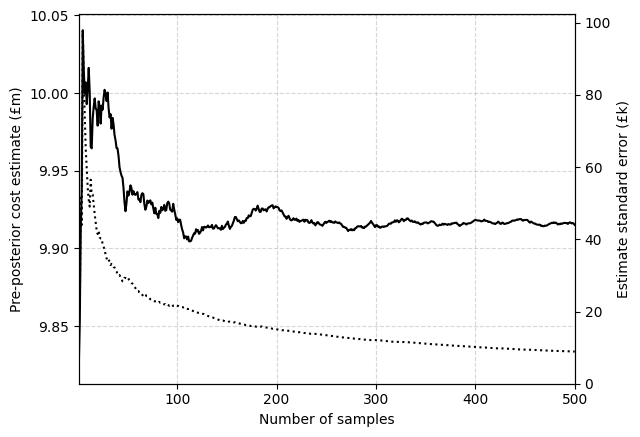

In [19]:
# Plot convergence of pre-posterior cost MC estimate.

MC_means = [np.mean(preposterior_costs[:i]) for i in range(1,n_prior_samples+1)]
MC_stnd_errors = [np.std(preposterior_costs[:i])/np.sqrt(i) for i in range(2,n_prior_samples+1)]

fig,ax = plt.subplots()
ax.set_xlim(1,n_prior_samples)
ax.set_xlabel("Number of samples")
ax.grid(True,'major',alpha=0.5,linestyle='--')

ax.plot(range(1,n_prior_samples+1),np.array(MC_means)/1e6,'-k')
ax.set_ylabel('Pre-posterior cost estimate (£m)')
#ax.set_ylim(0)

# min_ax = ax.twinx()
# min_ax.plot(range(2,n_draws+1),(np.array(MC_stnd_errors)/MC_means[-1])*100,'k--')
# min_ax.set_ylabel('Estimate standard error (% of final mean)')
# min_ax.set_ylim(0)

min_ax_abs = ax.twinx()
min_ax_abs.plot(range(2,n_prior_samples+1),np.array(MC_stnd_errors)/1e3,'k:')
min_ax_abs.set_ylabel('Estimate standard error (£k)')
min_ax_abs.set_ylim(0)

plt.show()

### Test quality of surrogate posterior optimal solutions

Note - this calculation is extremely hefty! However, we can use a random sub-sample of solutions to estimate mean quality (note solutions are already randomly ordered)

In [20]:
mproc_args_list = []
for i, (posterior_result,eta_sample) in enumerate(zip(posterior_optimal_results,prior_eta_samples)):
    mproc_args_list.append([posterior_result.x[:len(ids)],posterior_result.x[len(ids):],eta_sample,base_kwargs,pricing_dict,opex_factor,i])
true_posterior_soln_cost = parallel_task(multi_proc_constr_and_eval_system, mproc_args_list, n_procs=n_processes)

100%|██████████| 500/500 [47:48<00:00,  5.74s/it]  


In [21]:
print("Predicted posterior solution costs: ",preposterior_costs)
print("Estimates of true posterior solution costs: ",true_posterior_soln_cost)
mean_posterior_soln_fn_error = np.mean(np.abs(np.array(true_posterior_soln_cost)-np.array(preposterior_costs)))
mean_posterior_soln_fn_error_perc = np.mean((np.abs(np.array(true_posterior_soln_cost)-np.array(preposterior_costs))/np.array(true_posterior_soln_cost))*100)
print(f"Surrogate mean posterior optimal solution fn error: {round(mean_posterior_soln_fn_error,2)}, {round(mean_posterior_soln_fn_error_perc,2)}%")

Predicted posterior solution costs:  [9823695.561057052, 9881838.191721106, 10034946.46464043, 10011039.628076801, 10448773.464969892, 9893687.020043397, 9904309.54202561, 10056873.103190206, 9881035.426586038, 10087902.796375696, 10154803.810226453, 9828864.312663564, 9543397.75310321, 9951018.27969762, 10251412.3193698, 10105782.247051226, 10082596.680928158, 9882252.008055966, 9965175.99206639, 9791536.523658926, 10307747.865486467, 9919893.843823012, 9740318.301555045, 10259489.807714853, 9925901.254698938, 10193292.714236703, 10130271.64020076, 9920363.47035355, 9872140.218127696, 10161275.32048312, 9686862.04648395, 9799584.423723312, 10054268.790262831, 9668374.359695584, 10221426.825280098, 9832787.58941082, 9723551.675846677, 9845838.16605726, 9777243.996649763, 9953092.134072166, 9765130.4175287, 9658091.40594391, 9816515.996085644, 9846226.485746136, 9887982.010308566, 9643238.361264944, 9508734.610373374, 9650224.509482082, 10186300.215024782, 10299301.98978132, 9799818.383

In [22]:
# Graph posterior solution error results?

## Step 4: Report VOI Result

We can use the standard error on the pre-posterior cost MC estimate as an error for result reporting.

In [23]:
print("VOI: %s"%round(prior_cost-preposterior_cost,2))
print("plus-minus: %s"%round(np.std(preposterior_costs)/np.sqrt(n_prior_samples),2))

VOI: 16300.81
plus-minus: 8935.06


In [24]:
print(prior_cost,preposterior_cost)

9931466.329845376 9915165.523735126


In [25]:
print("Prior cost check: ",np.mean(prior_soln_performances),prior_cost)
print("Regret based VoI: ",round((np.mean(prior_soln_performances)-preposterior_cost),2))

Prior cost check:  9932360.745289566 9931466.329845376
Regret based VoI:  17195.22
